In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/selfDACON_pj01')
from DACON_pj01 import mySetting, myTrain

In [3]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [4]:
import random
import pandas as pd
import numpy as np
import os, re, glob, cv2
from PIL import Image 
import matplotlib.pyplot as plt
# plt.rc('font', family='NanumBarunGothic')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.utils.data import Subset

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torchvision import transforms
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm
from copy import deepcopy

import warnings
warnings.filterwarnings(action='ignore') 

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [6]:
setting = mySetting(seed=41)
setting.seedSetting() # seed 고정

### 1. 데이터 전처리

In [7]:
data_path = '/content/drive/MyDrive/Colab Notebooks/DACON_pj01_data'
setting.getDataframe(data_path)

transform = A.Compose([A.Resize(224,224), # 224,224
                       A.Normalize(), #mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                       A.HorizontalFlip(p=0.3),
                       A.RandomBrightnessContrast(p=0.3),
                       ToTensorV2()])
setting.getDataset(transform, using='A')

batch_s = 10
setting.getDataloader(batch_s)

train, valid, test: 2765 692 792
train, valid, test: 277 70 80
trainloader shape torch.Size([10, 3, 224, 224]) torch.Size([10])


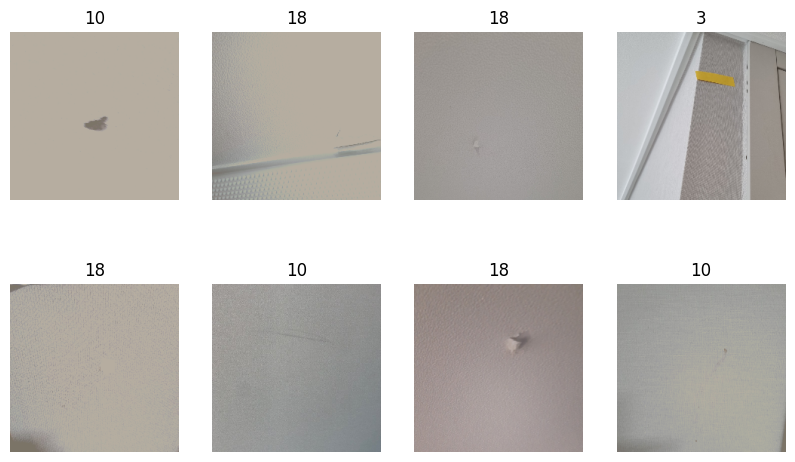

{1: '걸레받이수정',
 0: '가구수정',
 2: '곰팡이',
 3: '꼬임',
 4: '녹오염',
 5: '들뜸',
 6: '면불량',
 7: '몰딩수정',
 9: '석고수정',
 8: '반점',
 11: '오타공',
 10: '오염',
 12: '울음',
 18: '훼손',
 16: '틈새과다',
 14: '창틀,문틀수정',
 17: '피스',
 13: '이음부불량',
 15: '터짐'}

In [8]:
setting.showimg()
setting.labels_map

### 2. model 설정

In [9]:
model = models.resnet152(weights=True)
for parameter in model.parameters():
    parameter.requires_grad = False 
for parameter in model.fc.parameters(): # classifier bolck: fc
    parameter.requires_grad = True 
model.fc = nn.Sequential(nn.Linear(2048,512),
                          nn.BatchNorm1d(512), nn.ReLU(),
                          nn.Dropout(0.3),
                          nn.Linear(512,len(setting.le.classes_))) # 19
model.fc

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:05<00:00, 47.9MB/s]


Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=512, out_features=19, bias=True)
)

### 3. 학습

- lr=0.0001, bs=8, t=(norm,hori,contrastbright), model=res152, fc=(2048,512,do(0.3),19)

train, valid, test: 346 87 99
trainloader shape torch.Size([8, 3, 224, 224]) torch.Size([8])


  0%|          | 0/346 [00:00<?, ?it/s]

Epoch : 2/55....... Train Loss : 1.665 Valid Loss : 1.265 Valid F1 Score : 0.546


  0%|          | 0/346 [00:00<?, ?it/s]

Epoch : 3/55....... Train Loss : 1.206 Valid Loss : 1.211 Valid F1 Score : 0.585


  0%|          | 0/346 [00:00<?, ?it/s]

Epoch : 4/55....... Train Loss : 1.076 Valid Loss : 1.111 Valid F1 Score : 0.616


  0%|          | 0/346 [00:00<?, ?it/s]

Epoch : 5/55....... Train Loss : 0.984 Valid Loss : 1.157 Valid F1 Score : 0.615
Epoch 00004: reducing learning rate of group 0 to 5.0000e-05.


  0%|          | 0/346 [00:00<?, ?it/s]

Epoch : 6/55....... Train Loss : 0.872 Valid Loss : 1.110 Valid F1 Score : 0.604


  0%|          | 0/346 [00:00<?, ?it/s]

Epoch : 7/55....... Train Loss : 0.841 Valid Loss : 1.118 Valid F1 Score : 0.614


  0%|          | 0/346 [00:00<?, ?it/s]

Epoch : 8/55....... Train Loss : 0.805 Valid Loss : 1.107 Valid F1 Score : 0.621
Epoch 00007: reducing learning rate of group 0 to 2.5000e-05.


  0%|          | 0/346 [00:00<?, ?it/s]

Epoch : 9/55....... Train Loss : 0.777 Valid Loss : 1.079 Valid F1 Score : 0.614


  0%|          | 0/346 [00:00<?, ?it/s]

Epoch : 10/55....... Train Loss : 0.742 Valid Loss : 1.071 Valid F1 Score : 0.615


  0%|          | 0/346 [00:00<?, ?it/s]

Epoch : 11/55....... Train Loss : 0.715 Valid Loss : 1.094 Valid F1 Score : 0.627
Epoch 00010: reducing learning rate of group 0 to 1.2500e-05.


  0%|          | 0/346 [00:00<?, ?it/s]

Epoch : 12/55....... Train Loss : 0.688 Valid Loss : 1.122 Valid F1 Score : 0.616


  0%|          | 0/346 [00:00<?, ?it/s]

Epoch : 13/55....... Train Loss : 0.675 Valid Loss : 1.071 Valid F1 Score : 0.626


  0%|          | 0/346 [00:00<?, ?it/s]

Epoch : 14/55....... Train Loss : 0.661 Valid Loss : 1.046 Valid F1 Score : 0.628
Epoch 00013: reducing learning rate of group 0 to 6.2500e-06.


  0%|          | 0/346 [00:00<?, ?it/s]

Epoch : 15/55....... Train Loss : 0.653 Valid Loss : 1.050 Valid F1 Score : 0.623

Early Stopping!! epoch/epochs: 14/55


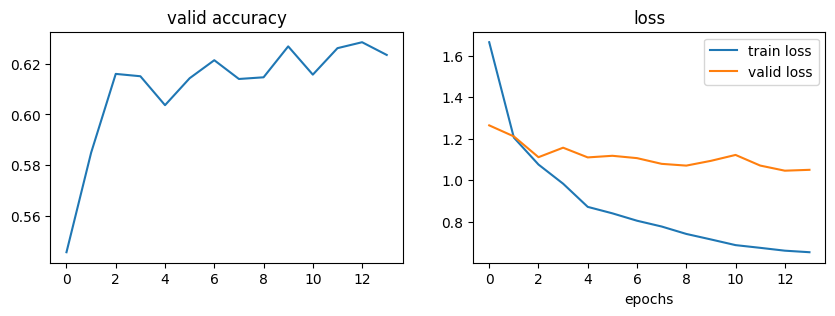

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

In [14]:
batch_s = 8
setting.getDataloader(batch_s)
model = models.resnet152(weights=True)
for parameter in model.parameters():
    parameter.requires_grad = False 
for parameter in model.fc.parameters(): # classifier bolck: fc
    parameter.requires_grad = True 
model.fc = nn.Sequential(nn.Linear(2048,512),
                          nn.BatchNorm1d(512), nn.ReLU(),
                          nn.Dropout(0.3),
                          nn.Linear(512,len(setting.le.classes_))) # 19
lr = 0.0001; patience = 7; epochs = 55
model = model.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=lr) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, 
                                                       threshold_mode='abs', min_lr=1e-8, verbose=True)

myNN = myTrain(model, loss_fn, optimizer, setting.trainloader, setting.validloader, setting.testloader, 
             scheduler, device, setting.le, epochs, patience, batch_s)
myNN.train_loop()
myNN.result_plot()
torch.save(myNN.model.state_dict(), 'last_checkpoint.pth')
test_preds = myNN.evaluate(myNN.model, myNN.testloader, myNN.loss_fn)
last_preds = myNN.load_model('last_checkpoint.pth', model, setting.testloader, loss_fn)
best_preds = myNN.load_model('best_checkpoint.pth', model, setting.testloader, loss_fn)

- lr=0.0001, bs=12, t=(norm,hori,contrastbright), model=res152, fc=(2048,512,do(0.3),256,19)
- resize 250

train, valid, test: 231 58 66
trainloader shape torch.Size([12, 3, 224, 224]) torch.Size([12])


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch : 2/55....... Train Loss : 1.741 Valid Loss : 1.313 Valid F1 Score : 0.525


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch : 3/55....... Train Loss : 1.187 Valid Loss : 1.171 Valid F1 Score : 0.592


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch : 4/55....... Train Loss : 1.035 Valid Loss : 1.139 Valid F1 Score : 0.576


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch : 5/55....... Train Loss : 0.962 Valid Loss : 1.120 Valid F1 Score : 0.618
Epoch 00004: reducing learning rate of group 0 to 5.0000e-05.


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch : 6/55....... Train Loss : 0.842 Valid Loss : 1.123 Valid F1 Score : 0.621


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch : 7/55....... Train Loss : 0.805 Valid Loss : 1.055 Valid F1 Score : 0.628


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch : 8/55....... Train Loss : 0.768 Valid Loss : 1.100 Valid F1 Score : 0.616
Epoch 00007: reducing learning rate of group 0 to 2.5000e-05.


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch : 9/55....... Train Loss : 0.735 Valid Loss : 1.075 Valid F1 Score : 0.633


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch : 10/55....... Train Loss : 0.716 Valid Loss : 1.055 Valid F1 Score : 0.626


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch : 11/55....... Train Loss : 0.696 Valid Loss : 1.052 Valid F1 Score : 0.630
Epoch 00010: reducing learning rate of group 0 to 1.2500e-05.


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch : 12/55....... Train Loss : 0.674 Valid Loss : 1.063 Valid F1 Score : 0.632


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch : 13/55....... Train Loss : 0.664 Valid Loss : 1.086 Valid F1 Score : 0.613


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch : 14/55....... Train Loss : 0.640 Valid Loss : 1.060 Valid F1 Score : 0.647
Epoch 00013: reducing learning rate of group 0 to 6.2500e-06.


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch : 15/55....... Train Loss : 0.640 Valid Loss : 1.047 Valid F1 Score : 0.631


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch : 16/55....... Train Loss : 0.630 Valid Loss : 1.034 Valid F1 Score : 0.636

Early Stopping!! epoch/epochs: 15/55


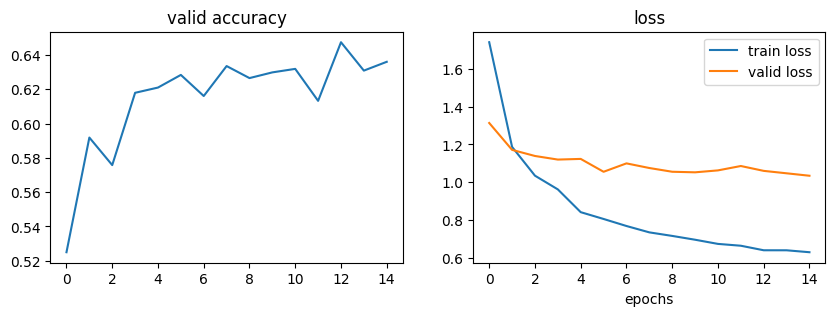

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

In [16]:
batch_s = 12
setting.getDataloader(batch_s)
model2 = models.resnet152(weights=True)
for parameter in model2.parameters():
    parameter.requires_grad = False 
for parameter in model2.fc.parameters(): # classifier bolck: fc
    parameter.requires_grad = True 
model2.fc = nn.Sequential(nn.Sequential(nn.Linear(2048,512),
                          nn.BatchNorm1d(512), nn.ReLU(),
                          nn.Dropout(0.3),
                          nn.Linear(512,len(setting.le.classes_)))) # 19
lr = 0.0001; patience = 7; epochs = 55
model2 = model2.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model2.parameters(), lr=lr) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, 
                                                       threshold_mode='abs', min_lr=1e-8, verbose=True)

myNN2 = myTrain(model2, loss_fn, optimizer, setting.trainloader, setting.validloader, setting.testloader, 
             scheduler, device, setting.le, epochs, patience, batch_s)
myNN2.train_loop()
myNN2.result_plot()
torch.save(myNN2.model.state_dict(), 'last_checkpoint.pth')
test_preds2 = myNN2.evaluate(myNN2.model, myNN2.testloader, myNN2.loss_fn)
last_preds2 = myNN2.load_model('last_checkpoint.pth', model2, setting.testloader, loss_fn)
best_preds2 = myNN2.load_model('best_checkpoint.pth', model2, setting.testloader, loss_fn)

- lr=0.0001, bs=16, t=(norm,hori,contrastbright), model=res152, fc=(2048,512,do(0.3),128,do(0.3),19)

train, valid, test: 173 44 50
trainloader shape torch.Size([16, 3, 224, 224]) torch.Size([16])


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch : 2/55....... Train Loss : 1.752 Valid Loss : 1.303 Valid F1 Score : 0.542


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch : 3/55....... Train Loss : 1.175 Valid Loss : 1.198 Valid F1 Score : 0.562


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch : 4/55....... Train Loss : 1.027 Valid Loss : 1.129 Valid F1 Score : 0.610


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch : 5/55....... Train Loss : 0.929 Valid Loss : 1.076 Valid F1 Score : 0.604
Epoch 00004: reducing learning rate of group 0 to 5.0000e-05.


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch : 6/55....... Train Loss : 0.834 Valid Loss : 1.068 Valid F1 Score : 0.623


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch : 7/55....... Train Loss : 0.785 Valid Loss : 1.030 Valid F1 Score : 0.630


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch : 8/55....... Train Loss : 0.769 Valid Loss : 1.054 Valid F1 Score : 0.618
Epoch 00007: reducing learning rate of group 0 to 2.5000e-05.


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch : 9/55....... Train Loss : 0.724 Valid Loss : 1.050 Valid F1 Score : 0.623


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch : 10/55....... Train Loss : 0.712 Valid Loss : 1.048 Valid F1 Score : 0.619


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch : 11/55....... Train Loss : 0.701 Valid Loss : 1.043 Valid F1 Score : 0.628
Epoch 00010: reducing learning rate of group 0 to 1.2500e-05.


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch : 12/55....... Train Loss : 0.671 Valid Loss : 1.016 Valid F1 Score : 0.634


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch : 13/55....... Train Loss : 0.655 Valid Loss : 1.022 Valid F1 Score : 0.634


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch : 14/55....... Train Loss : 0.664 Valid Loss : 1.032 Valid F1 Score : 0.628
Epoch 00013: reducing learning rate of group 0 to 6.2500e-06.


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch : 15/55....... Train Loss : 0.640 Valid Loss : 1.004 Valid F1 Score : 0.638


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch : 16/55....... Train Loss : 0.634 Valid Loss : 1.029 Valid F1 Score : 0.631


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch : 17/55....... Train Loss : 0.628 Valid Loss : 1.033 Valid F1 Score : 0.612

Early Stopping!! epoch/epochs: 16/55


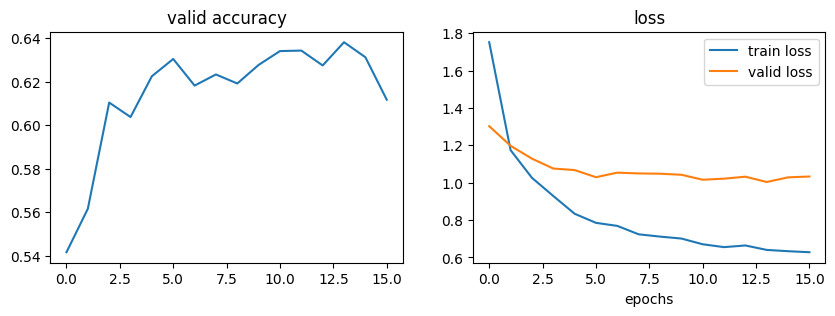

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [17]:
batch_s = 16
setting.getDataloader(batch_s)
model3 = models.resnet152(weights=True)
for parameter in model3.parameters():
    parameter.requires_grad = False 
for parameter in model3.fc.parameters(): # classifier bolck: fc
    parameter.requires_grad = True 
model3.fc = nn.Sequential(nn.Sequential(nn.Linear(2048,512),
                          nn.BatchNorm1d(512), nn.ReLU(),
                          nn.Dropout(0.3),
                          nn.Linear(512,len(setting.le.classes_)))) # 19
lr = 0.0001; patience = 7; epochs = 55
model3 = model3.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model3.parameters(), lr=lr) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, 
                                                       threshold_mode='abs', min_lr=1e-8, verbose=True)

myNN3 = myTrain(model3, loss_fn, optimizer, setting.trainloader, setting.validloader, setting.testloader, 
             scheduler, device, setting.le, epochs, patience, batch_s)
myNN3.train_loop()
myNN3.result_plot()
torch.save(myNN3.model.state_dict(), 'last_checkpoint.pth')
test_preds3 = myNN3.evaluate(myNN3.model, myNN3.testloader, myNN3.loss_fn)
last_preds3 = myNN3.load_model('last_checkpoint.pth', model3, setting.testloader, loss_fn)
best_preds3 = myNN3.load_model('best_checkpoint.pth', model3, setting.testloader, loss_fn)

### 4. Submission

In [18]:
date = '0423'
submit = pd.read_csv(data_path+'/sample_submission.csv')
submit['label'] = test_preds
submit.to_csv('/content/drive/MyDrive/Colab Notebooks/selfDACON_pj01/output/{}_test_submit.csv'.format(date), index=False)
submit['label'] = last_preds
submit.to_csv('/content/drive/MyDrive/Colab Notebooks/selfDACON_pj01/output/{}_last_submit.csv'.format(date), index=False)
submit['label'] = best_preds
submit.to_csv('/content/drive/MyDrive/Colab Notebooks/selfDACON_pj01/output/{}_best_submit.csv'.format(date), index=False)

In [19]:
date = '0423_2'
submit = pd.read_csv(data_path+'/sample_submission.csv')
submit['label'] = test_preds2
submit.to_csv('/content/drive/MyDrive/Colab Notebooks/selfDACON_pj01/output/{}_test_submit.csv'.format(date), index=False)
submit['label'] = last_preds2
submit.to_csv('/content/drive/MyDrive/Colab Notebooks/selfDACON_pj01/output/{}_last_submit.csv'.format(date), index=False)
submit['label'] = best_preds2
submit.to_csv('/content/drive/MyDrive/Colab Notebooks/selfDACON_pj01/output/{}_best_submit.csv'.format(date), index=False)

In [20]:
date = '0423_3'
submit = pd.read_csv(data_path+'/sample_submission.csv')
submit['label'] = test_preds3
submit.to_csv('/content/drive/MyDrive/Colab Notebooks/selfDACON_pj01/output/{}_test_submit.csv'.format(date), index=False)
submit['label'] = last_preds3
submit.to_csv('/content/drive/MyDrive/Colab Notebooks/selfDACON_pj01/output/{}_last_submit.csv'.format(date), index=False)
submit['label'] = best_preds3
submit.to_csv('/content/drive/MyDrive/Colab Notebooks/selfDACON_pj01/output/{}_best_submit.csv'.format(date), index=False)

In [ ]:
class mySetting():
    def __init__(self, seed):
        self.seed = seed
                
    def seedSetting(self):
        random.seed(self.seed)
        os.environ['PYTHONHASHSEED'] = str(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed(self.seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
        return

    def getDataframe(self, data_path):
        self.data_path = data_path
        df = pd.DataFrame(data={'img_path':glob.glob(data_path+'/train/*/*')})
        df['label'] = df['img_path'].apply(lambda x: str(x).split('/')[-2])
        self.label_li = df['label'].unique().tolist()
        self.train_df, self.valid_df, _, _ = train_test_split(df, df['label'], test_size=0.2, 
                                                stratify=df['label'], random_state=self.seed)
        self.le = LabelEncoder()
        self.train_df['label'] = self.le.fit_transform(self.train_df['label'])
        self.valid_df['label'] = self.le.transform(self.valid_df['label'])
        self.test_df = pd.read_csv(data_path+'/test.csv')
        self.test_df['img_path'] = (data_path + self.test_df['img_path']).str.replace('data./test','data/test')
        return self
        
    def getDataset(self, transform, using='transforms'):
        self.trainset = mycreateDataset(self.train_df['img_path'].values, self.train_df['label'].values, transform, using)
        self.validset = mycreateDataset(self.valid_df['img_path'].values, self.valid_df['label'].values, transform, using)
        self.testset = mycreateDataset(self.test_df['img_path'].values, None, transform, using)
        print('train, valid, test:', len(self.trainset), len(self.validset), len(self.testset))
        return self
    
    def getDataloader(self, batch_s=16):
        self.trainloader = DataLoader(self.trainset, batch_size=batch_s, shuffle=False, num_workers=0)
        self.validloader = DataLoader(self.validset, batch_size=batch_s, shuffle=False, num_workers=0)
        self.testloader = DataLoader(self.testset, batch_size=batch_s, shuffle=False, num_workers=0)
        print('train, valid, test:', len(self.trainloader), len(self.validloader), len(self.testloader))
        train_iter = iter(self.trainloader)
        imgs, labels = train_iter.__next__()
        print('trainloader shape', imgs.shape, labels.shape)
        return self
    
    def getTest(self, transform, using='transforms', batch_s=16):
        self.testset = mycreateDataset(self.test_df['img_path'].values, None, transform, using)
        self.testloader = DataLoader(self.testset, batch_size=batch_s, shuffle=False, num_workers=0)
        return self
    
    def showimg(self):
        self.labels_map = {}
        for k,v in zip(self.le.transform(self.label_li), self.label_li):
            self.labels_map[k] = v
        fig, ax = plt.subplots(2,4, figsize=(10,6))
        ax = ax.flatten()
        for i in range(8):
            item = self.trainset[np.random.randint(0, len(self.trainset))]
            img, label = item[0].permute(1,2,0), item[1]
            img.mul_(torch.tensor([0.229, 0.224, 0.225])) # std
            img.add_(torch.tensor([0.485, 0.456, 0.406])) # mean
            ax[i].axis('off'); ax[i].imshow(img)
            ax[i].set_title(str(label))  # (self.labels_map[label])
        plt.show()
        return self

class mycreateDataset(Dataset):
    def __init__(self, filepaths, labels, transform, using='transforms'):
        self.filepaths, self.labels = filepaths, labels
        self.transform = transform
        self.using = using

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        if self.labels is not None: img_filepath = self.filepaths[idx]
        else: img_filepath = self.filepaths[idx]
        img = Image.open(img_filepath).convert('RGB')
        if self.using=='A': 
            img = np.array(img)
            transed_img = self.transform(image=img)['image']
        else: 
            transed_img = self.transform(img)
        if self.labels is not None:
            return transed_img, self.labels[idx]
        else: return transed_img

In [ ]:
class mytrain():
    def __init__(self, model, loss_fn, optimizer, trainloader, validloader, testloader, 
                 scheduler, device, le, epochs=30, patience=5, batch_s=16):
        self.model, self.loss_fn, self.optimizer = model, loss_fn, optimizer
        self.trainloader, self.validloader, self.testloader = trainloader, validloader, testloader
        self.scheduler, self.device = scheduler, device
        self.epochs, self.patience, self.batch_s = epochs, patience, batch_s
        self.le = le
        self.train_loss_li, self.valid_loss_li, self.valid_f1_li = [], [], []
        
    def train_loop(self):
        # self.loss_fn = self.loss_fn.to(device)

        best_f1 = 0; trigger = 0
        train_loss_li, valid_loss_li, valid_f1_li = [], [], []
        for epoch in range(1,self.epochs+1):
            self.model.train() 
            train_loss = 0
            for imgs, labels in tqdm(self.trainloader):
                imgs, labels = imgs.to(self.device), labels.to(self.device)

                loss = self.loss_fn(self.model(imgs), labels) 
                self.optimizer.zero_grad() 
                loss.backward() 
                self.optimizer.step() 
                train_loss += loss.item()

            valid_loss, valid_f1 = self.validate()
            print('Epoch : {}/{}.......'.format(epoch+1, self.epochs),            
                  'Train Loss : {:.3f}'.format(train_loss/len(self.trainloader)), 
                  'Valid Loss : {:.3f}'.format(valid_loss),
                  'Valid F1 Score : {:.3f}'.format(valid_f1))
            train_loss_li.append(train_loss/len(self.trainloader))
            valid_loss_li.append(valid_loss)
            valid_f1_li.append(valid_f1)

            if valid_f1<best_f1:
                trigger += 1
                if trigger > self.patience:
                    print('\nEarly Stopping!! epoch/epochs: {}/{}'.format(epoch, self.epochs))
                    break
            else:
                best_f1 = valid_f1
                best_model_state = deepcopy(self.model.state_dict())
                torch.save(best_model_state, 'best_checkpoint.pth') 

            self.scheduler.step(valid_loss)
        self.train_loss_li, self.valid_loss_li, self.valid_f1_li = train_loss_li, valid_loss_li, valid_f1_li
        return

    def validate(self):
        self.model.eval()
        loss, preds, true_labels = 0, [], []
        with torch.no_grad():
            for imgs, labels in self.validloader:
                imgs, labels = imgs.to(self.device), labels.to(self.device)
                pred = self.model(imgs)
                # _, preds = torch.max(pred, 1)
                preds += pred.argmax(1).detach().cpu().numpy().tolist()
                true_labels += labels.detach().cpu().numpy().tolist()
                loss += self.loss_fn(pred, labels).item()
        return loss/len(self.validloader), f1_score(true_labels, preds, average='weighted')

    def result_plot(self):
        fig, ax = plt.subplots(1,2, figsize=(10,3))
        x = np.arange(len(self.train_loss_li))
        ax[0].plot(x, self.valid_f1_li, label='valid_F1_score')
        ax[0].set_title('valid accuracy')
        ax[1].plot(x, self.train_loss_li, label='train loss')
        ax[1].plot(x, self.valid_loss_li, label='valid loss')
        ax[1].set_title('loss')
        plt.xlabel('epochs'); plt.legend(loc='best')
        plt.show()
        
    def evaluate(self, model, testloader, loss_fn):
        model.eval()
        preds = []
        with torch.no_grad():
            for imgs in tqdm(testloader):
                imgs = imgs.to(self.device)
                pred = model(imgs)
                # _, preds = torch.max(logit, 1)
                preds += pred.argmax(1).detach().cpu().numpy().tolist()
        return self.le.inverse_transform(preds)

    def load_model(self, dirct, model, testloader, loss_fn):
        state_dict = torch.load(dirct)
        load_model = model
        load_model.load_state_dict(state_dict)
        return self.evaluate(load_model, testloader, loss_fn)